In [1]:
import numpy as np
import os
from math import ceil

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
for filename in sorted(os.listdir('./rezende_data/'))[::-1]:
    print(filename)
#     file = os.path.join('./', 'rezende_data', filename)
#     current_data = np.loadtxt(file)

nuts_3.txt
nuts_2.txt
nuts_1.txt
nuts_0.txt
hoffman_3.txt
hoffman_2.txt
hoffman_1.txt
hoffman_0.txt


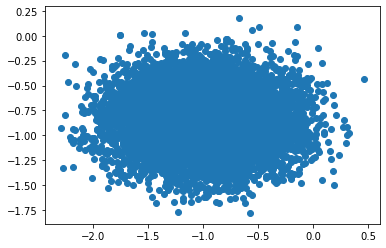

In [22]:
data = np.loadtxt(os.path.join('./', 'rezende_data', 'hoffman_3.txt'))
plt.scatter(data[:, 0], data[:, 1])